# Example: Inspecting a NeXus file

To demonstrate that the `h5rdmtoolbox` works with [NeXus](https://manual.nexusformat.org/fileformat.html) files, we download a file and inspect it. Note that by "works" we don't mean that the data model of NeXus is understood by the toolbox. Rather, we want to demonstrate that we can identify specific data in the file, plot it, and apply a minimal example of convention and layout validation that we will quickly design here.

In [1]:
import h5rdmtoolbox as h5tbx
from h5rdmtoolbox.database.hdfdb import logger
logger.setLevel('DEBUG')

## 1. Get the file

In [2]:
import requests
import pathlib

if not pathlib.Path('file.nxs').exists():
    r = requests.get('https://github.com/nexusformat/exampledata/raw/master/Soleil/hdf5/file_1.nxs')
    with open('file.nxs', 'wb') as f:
        f.write(r.content)

## 2. Visit (Dump) the file

In [3]:
h5tbx.dump('file.nxs')

C:\Users\da4323\Documents\programming\GitHub\h5RDMtoolbox\h5rdmtoolbox\_repr.py:489: RuntimeWarning: Cannot decode attribute value for units
  warnings.warn(f'Cannot decode attribute value for {name}', RuntimeWarning)


## 3. Find and plot data

In [4]:
obj = h5tbx.database.FileDB('file.nxs').find_one({'$name': {'$basename': 'image#5'}},   
                                                 recursive=True)
obj

<LGroup "/NDX3_00021_ND__DLPC__00001/image#5" in "file.nxs">

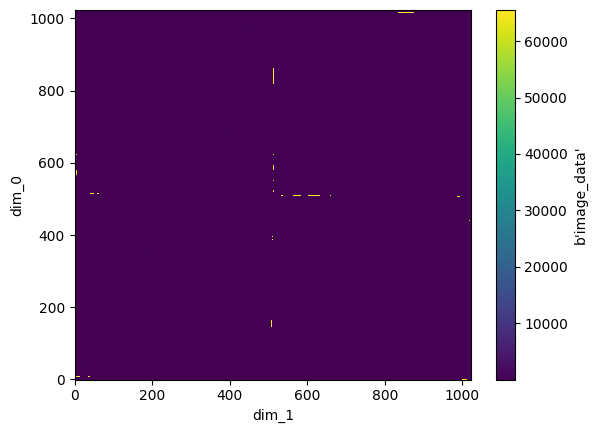

In [5]:
obj.data[()].plot()  # note, we can access children (e.g. dataset "data") of the (lazy) group

## 4. Write a standard attribute for timestamp

If you carefully check the `dump` output, you will find, that all numeric (!) datasets have the attribute "timestamp". All of them? Well, let's write a convention, which defines that providing the attribute "timestamp" with every numeric dataset is *required*. The timestamp value must have a specific format.

Let's create the standard name first:

### 4.1 Standard Name "timestamp"

In [6]:
from h5rdmtoolbox.convention import StandardAttribute

from pydantic import BaseModel, ValidationError
from pydantic.functional_validators import AfterValidator, Annotated
from datetime import datetime
from typing import Union

def parse_datetime(v: Union[str, datetime]) -> str:
    """validation function used by the pydantic model class"""
    _format = '%Y-%m-%dT%H-%M-%S.%f'
    if isinstance(v, datetime):
        return v.strftime(_format)
    return datetime.strptime(v, _format).strftime(_format)

class NexusTimeStampObject(BaseModel):
    """The standard name table of the convention."""
    value: Annotated[str, AfterValidator(parse_datetime)]

NexusTimeStamp = StandardAttribute('timestamp',
                                   validator=NexusTimeStampObject,
                                   target_method='create_dataset',
                                   description='Timestamp of writing the data',
                                  default_value='$EMPTY')

### 4.2 Build the convention

In [7]:
from h5rdmtoolbox.convention import Convention

cv = Convention(name='nexus', contact=h5tbx.__author__)

cv.add_standard_attribute(NexusTimeStamp)
cv.register()

h5tbx.use(cv)

using("nexus")

First test the convention on a temporary file:

In [8]:
with h5tbx.File() as h5:
    h5.create_dataset('test', data=4, timestamp='2008-10-23T15-09-39.175')
    h5.dump()

In [9]:
# should raise an error due to NO timestamp
with h5tbx.File() as h5:
    try:
        h5.create_dataset('test', data=4)
    except h5tbx.errors.StandardAttributeError as e:
        print(e)

Convention "nexus" expects standard attribute "timestamp" to be provided as an argument during dataset creation.


In [10]:
# should raise an error due to a wrong timestamp
with h5tbx.File() as h5:
    try:
        h5.create_dataset('test', data=4, timestamp='2008 10 23 15-09-39.175')
    except h5tbx.errors.StandardAttributeError as e:
        print(e)

Validation of "2008 10 23 15-09-39.175" for standard attribute "timestamp" failed.
Expected fields: {'value': FieldInfo(annotation=str, required=True, metadata=[AfterValidator(func=<function parse_datetime at 0x000001CE14B65160>)])}
Pydantic error: 1 validation error for NexusTimeStampObject
value
  Value error, time data '2008 10 23 15-09-39.175' does not match format '%Y-%m-%dT%H-%M-%S.%f' [type=value_error, input_value='2008 10 23 15-09-39.175', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/value_error


### 4.3 Validate the NeXus file based on the convention:

We find, that two datasets in fact have no timestamp!

In [11]:
invalid_objs = cv.validate('file.nxs')
invalid_objs

[MissingAttribute(/NDX3_00021_ND__DLPC__00001/duration, timestamp),
 MissingAttribute(/NDX3_00021_ND__DLPC__00001/run_number, timestamp)]

Let's convince ourselves:

In [12]:
obj = h5tbx.database.FileDB('file.nxs').find_one({'$name': invalid_objs[0].object_name})
obj.attrs.get('timestamp', 'missing!!!')

'missing!!!'

In [13]:
h5tbx.use(None)

using("h5py")

## 5. Validating the file structure with a layout definition

The *structure* or *layout* defines which groups, datasets and attributes need to exist and in which arrangement. This cannot be defined/checked during file creation (using standard attributes).

Let's define part of a potential layout for the NeXus file in words first and then write the code:
1) **Ten datasets** starting with "image#" and ending with a number between 0 and 9
2) The group **user** must exist, which has the datasets "name" with the attribute "description"

The layout is defined by specifying queries, which correspond to what we are expecting in the file. If it is not found, the layout specification failed:

In [14]:
from h5rdmtoolbox import layout

lay = layout.Layout()

# 1.) 10 images:
spec_10images = lay.add(h5tbx.database.FileDB.find,
                      flt={'$name': {'$regex': '.*/image#[0-9]$'}},
                      n=10)

# 2.) User group. Identify by attribute "NX_class":
spec_userGroupExists = lay.add(h5tbx.database.FileDB.find,
                               flt={'NX_class': b'NXuser'})

# within the User group, find group "name":
spec_UserName = spec_userGroupExists.add(
    h5tbx.database.FileDB.find_one,
    flt={'$name': {'$basename': 'name'}}
)

# within the Name group find dataset "name" with a certain "description":
spec_UserNameDescription = spec_UserName.add(
    h5tbx.database.FileDB.find_one,
    flt={'$name': {'$basename': 'name'}, 'description': b'Name of user responsible for this entry'}  # !binary string!
)

Validate the file:

In [15]:
res = lay.validate('file.nxs')
res.is_valid()

True